# Online News Popularity Analysis and Prediction

In the recent decades, internet has become a popular source for people to learn about news. Among all the news published online, some become really popular, but others do not. In this project, we aim to predict whether a news article will become popular or not, based on some characteristics of the article, such as number of words, article topic, and etc.

In this notebook, we will use multiple machine learning models, such as KNN, Naive Bayes, QDA, LDA, Logistic Regression and Random Forest to perform classification. We will then compare the CV scores to determine the most appropriate model.

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Data Exploration and Feature Engineering

The dataset is collected from a well-known news website called Mashable, and the dataset is provided by UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

In the original dataset, there are 39,797 instances, with 61 features. 
Performed the following to clean up the dataset:
1. Columns contain news’ URL and days between the article publication and the dataset acquisition have been deleted (irrelevant information).

2. Combine the channel into one column (named as channel), and use numbers to represent each channel:
    1: Lifestyle
    2: Entertainment
    3: Business
    4: Social
    5: Tech
    6: World
    Delete the instance if channel information is missing (6287 instances have been deleted)
    
3. Combine the days into one column (named as days): 1 represents Mondy, 2 represents Tuesday, etc. Delete the column “is_weekend” (repetitive information).

    
After the cleaning process, the resulting dataset contains 33,510 instances, with 47 features.

(The above steps are performed directly on the csv data file in excel.)

### Assign the class

The goal is to perform the classification algorithm, so that based on the features of an article, we will be able to predict whether it will become popular or not. Thus, the first step is to define what is popular and what is not.

We will use the column "shares" as an indicator of popularity. Explore the "shares" column":

In [12]:
import pandas as pd
df = pd.read_csv('OnlineNewsPopularity.csv', sep=',') 

In [13]:
print(df[' shares'].describe())

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name:  shares, dtype: float64


{'boxes': [<matplotlib.lines.Line2D at 0x7f96bfca8410>],
 'caps': [<matplotlib.lines.Line2D at 0x7f96bfca2510>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f96bfc99550>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f96bfca2fd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f96bfca8a50>,
  <matplotlib.lines.Line2D at 0x7f96bfca8f90>]}

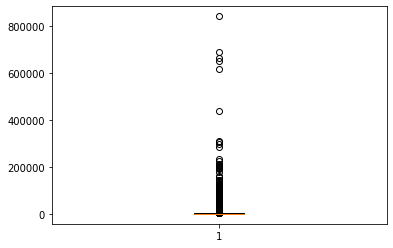

In [14]:
plt.boxplot(df[' shares'])

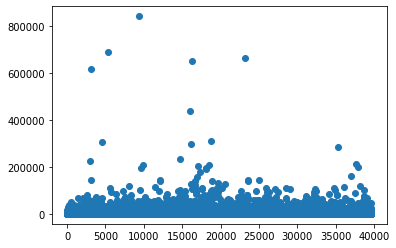

In [15]:
df[' shares'].plot(style='o')

From the boxplot and statistics summary, we could see that the target column "shares" has some outliers, but most of them are under 2500. For our purpose, we will regard the articles with shares > 1400 as popular, and not popular otherwise.

For the convenience of future use, directly add a column called "class" in the data csv file, and assign the classes as described above. The dataset is stored in "OnlineNewsPopularity2".csv

### Feature Selection - Fisher Score

We firstly calculate the Fisher Score of each feature, and rank them from the largest to smallest. 

F-score provides a measure of how well a single feature at a time can discriminate between different classes. The higher the F-score, the better the discriminatory power of that feature.

This process is performed using R, and the result table is shown here: 

(the R code is also available here:https://github.com/ruoxi430/News-Popularity )

<img src="https://github.com/Aafaq-Ahmed/News-Popularity/blob/master/picture.png?raw=1" width="400">

We keep the top 25 features with highest F-score. The change is directly done with the data csv file, and the data are stored in "OnlineNewsPopularity4".csv

In the next step, we calculated the covariance matrix for further feature selection.

### Feature Selection -  Covariance Matrix

In [16]:
df2 = pd.read_csv('OnlineNewsPopularity4.csv', sep=',')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
len(df2.columns)

27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  """


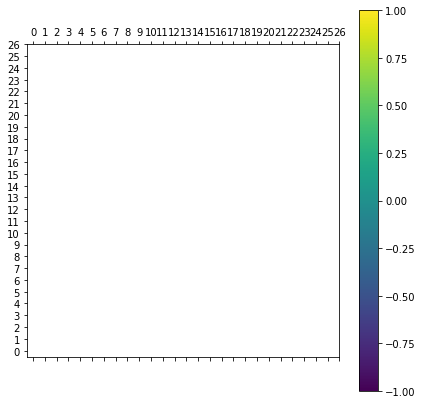

In [18]:
correlations = df2.corr()
# plot correlation matrix
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,27,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

It is easy to see there are several variables have high correlation. After considering the nature of these features, we elimintaed 6 highly correalted varaibles.

The final cleaned dataset version is stored in "OnlineNewsPopularityCleaned2.csv", with 19 features.

In [20]:
df3 = pd.read_csv('OnlineNewsPopularityCleaned2.csv', sep=',')

In [21]:
len(df3.columns)

21

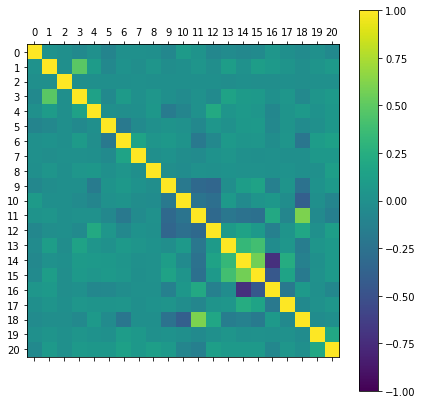

In [22]:
correlations2 = df3.corr()
# plot correlation matrix
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations2, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,21,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

Looks good now!

We could begin to train the classification models.

### 2. Naive Bayes, LDA, QDA

In [29]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [30]:
data2 = np.loadtxt('OnlineNewsPopularityCleaned2.csv', delimiter=',', skiprows=1)
target = data2[:,-1].reshape(len(data2),1)
features = data2[:,:-2]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30)

gnb = GaussianNB()
qda = QDA()
lda = LDA()

In [32]:
print(mean(cross_val_score(gnb, features, target, cv=5)))
print(mean(cross_val_score(qda, features, target, cv=5)))
print(mean(cross_val_score(lda, features, target, cv=5)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.5371232467920024


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5433005073112503


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.6115786332438079


### 3. Random Forest

In [33]:
df_t2 = pd.read_csv('OnlineNewsPopularityCleaned2.csv', sep=',')
data3 = df_t2.values

In [34]:
target3 = data3[1:,-1]
features3= data3[1:,:19]

In [35]:
#from sklearn import decomposition
#pca = decomposition.PCA(n_components=3, whiten=True)
#pca_feature = pca.fit_transform(features2)

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(n_estimators=300,max_depth=15,max_features=5)

In [37]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_target, test_target = train_test_split(features3, target3, test_size = 0.2, random_state = 42)

In [38]:
rf2.fit(train_features, train_target)

RandomForestClassifier(max_depth=15, max_features=5, n_estimators=300)

In [39]:
cross_val_score(rf2, features3,target3, cv=5)

array([0.61101164, 0.65383468, 0.65950463, 0.6786034 , 0.66348306])

In [40]:
np.mean([0.61345666, 0.65308863, 0.65652044, 0.67691389, 0.66527384])

0.6530506920000001

### Result Summary

The average accuracy of the classifiction models are:

Naive Bayes: 0.54

LDA:0.61

QDA:0.54

Random Forest:0.65


Random Forest has the best performance.

Also, from the random forest, we could also calcualte the feature importance:

In [41]:
df4 = pd.DataFrame(train_features)

In [42]:
df4.columns = ['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_keywords', 'kw_min_min', 'kw_avg_avg', 'self_reference_avg_sharess', 'day', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 
               'rate_negative_words', 'title_sentiment_polarity', 'channel']

In [43]:
feature_importances = pd.DataFrame(rf2.feature_importances_,
                                   index = df4.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [44]:
feature_importances

,importance
kw_avg_avg,0.104156
self_reference_avg_sharess,0.075524
LDA_02,0.067818
LDA_04,0.061936
n_unique_tokens,0.061032
LDA_00,0.060815
LDA_01,0.059952
n_tokens_content,0.057375
global_subjectivity,0.055858
global_sentiment_polarity,0.055803


From this, we could see that articles that refers to other popular articles, uses popular keywords, and discusses popular topics, are more likely to become popular.